# 2. PCA analysis and clustering

First, we reimport libraries, arrays and list we are going to use for this section (from previous notebook)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
class_labels = [0, 1, 2, 3, 4, 5]
class_names = ['bike', 'car', 'motorcycle', 'other', 'truck', 'van'] 
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange']

with np.load('train_features.npz') as train_data:
    train_features = train_data['features']
    train_labels = train_data['labels']

X_train = np.array(train_features)
y_train = np.array(train_labels)

with np.load('valid_features.npz') as valid_data:
    valid_features = valid_data['features']
    valid_labels = valid_data['labels']

X_valid = np.array(valid_features)
y_valid = np.array(valid_labels)

with np.load('test_features.npz') as test_data:
    test_features = test_data['features']
    test_labels = test_data['labels']

X_test = np.array(test_features)
y_test = np.array(test_labels)

We add validation images to train images as to increase size of training set

In [3]:
# Concatenate X_train and X_valid along the first axis
X_train = np.concatenate((X_train, X_valid), axis=0)
y_train = np.concatenate((y_train, y_valid), axis=0)

## PCA

Here, we first import the PCA class from scikit-learn. We specify n_components=None to indicate that we want to keep all principal components. We first check the range of values in each features of X_train gotten out of [MobileNet v2](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5). PCA is sensitive to the size of values as it tries to capture the largest variances. We calculate mean + std for features in X_train.

In [4]:
column_ranges = np.mean(X_train, axis=0) + np.std(X_train, axis=0)

# Sort
sorted_ranges = np.sort(column_ranges)

print("Top 5 ranges:", sorted_ranges[-20:])
print("Bottom 5 ranges:", sorted_ranges[:20])

Top 5 ranges: [1.6560078 1.6640697 1.6692498 1.6863952 1.6873236 1.6925402 1.7057095
 1.7505592 1.7607827 1.780848  1.7870442 1.7916452 1.8460958 1.8655297
 1.8903699 1.8963392 1.9134041 1.9458585 2.0728803 2.400529 ]
Bottom 5 ranges: [0.05802493 0.08419129 0.11318212 0.13038418 0.13452184 0.13885324
 0.14018591 0.14034088 0.1445295  0.1451769  0.1456196  0.14571662
 0.14747305 0.15005757 0.15169582 0.15229815 0.15918916 0.16411212
 0.16676214 0.16681232]


For a normal centered reduced Gaussian distribution, the value of the mean is 0 and the value of the standard deviation (std) is 1. Hence we chose not to apply standard scaler as a first step, as mean + std takes highest values at 2.40. We try a second time to apply a Standard Scaler to check whether we see improvement in variance explained by PCA first components.

### Rescaling vs no rescaling

In [5]:
# Instantiating two PCA with two components
pca_unscaled = PCA(n_components=2)
pca_rescaled = PCA(n_components=2)

# No Rescaling
pca_unscaled.fit(X_train)

# Rescaling
X_train_scaled = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
pca_rescaled.fit(X_train_scaled)

print("Unscaled variance explained:", pca_unscaled.explained_variance_ratio_)
print("Rescaled variance explained:", pca_rescaled.explained_variance_ratio_)

Unscaled variance explained: [0.13109116 0.07009637]
Rescaled variance explained: [0.09264267 0.05419017]


As the variance explained by the first two principal components is not vastly different (around 20% and 15% in rescaled data), we chose not to rescale data afterwards.

In [6]:
pca = PCA(n_components=None)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

#### Scree plot
How many PCA components explain 10%, 20%, …, 90% and 100% of the variance?

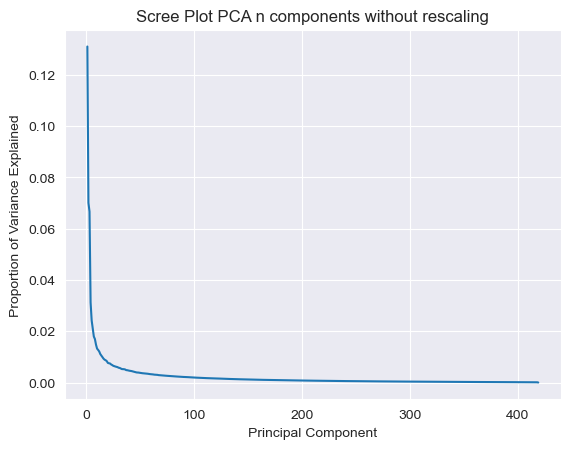

In [7]:
variance_ratios = pca.explained_variance_ratio_

cumulative_variance = np.cumsum(variance_ratios)

plt.plot(
    np.arange(1, len(variance_ratios) + 1),
    variance_ratios
)

plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot PCA n components without rescaling')
plt.show()

In [8]:
cumulative_variance.shape

(419,)

Cumulative variance is the array of all variance summed cumulatively. Note that shape is 419 and not 1280, limited by number of images in X_train rather than by number of features. To print, number of components that explain threshold of variance (10%, 20%,) we use np.where on cumulative_variance array to select position of cumulative sum that satisfies thereshold.

In [9]:
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    num_components = np.where(cumulative_variance >= threshold)[0][0] +1
    print(f'{threshold * 100}% variance explained by {num_components} components')

10.0% variance explained by 1 components
20.0% variance explained by 2 components
30.0% variance explained by 5 components
40.0% variance explained by 10 components
50.0% variance explained by 20 components
60.0% variance explained by 36 components
70.0% variance explained by 61 components
80.0% variance explained by 102 components
90.0% variance explained by 176 components


Actual scree plot

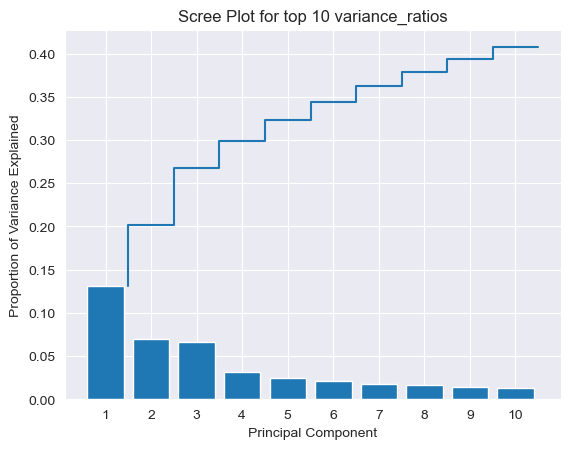

In [10]:
x = np.arange(1, 11)
plt.xticks(x)

plt.bar(x, variance_ratios[:10])

plt.step(x+.5,cumulative_variance[:10])

plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot for top 10 variance_ratios')
plt.show()

The variance explained by the first 10 components  is not very good. In the course example we were explaining 80% of variance with top 5 components, here we are explaining around 45% of variance using top 10 components.

## Transform using first two PCA Components
### Transformation
Transform training dataset using the first two PCA components

In [11]:
pca = PCA(n_components=2)

pca.fit(X_train)

X_train_pca = pca.transform(X_train)

In [12]:
X_train_pca.shape

(419, 2)

X_train_pca is properly an array of 419 features explained by the two first principal components.

### Visualization
Visualize the transformed data on a 2D-plot and use 6 different colors to designate the 6 categories. What can you say about the results?

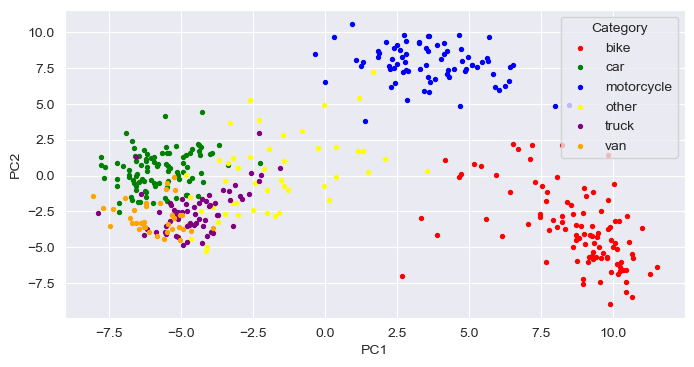

In [13]:
fig = plt.figure(figsize=(8, 4))
for i, color in enumerate(colors):
    plt.scatter(
        X_train_pca[y_train == i, 0],
        X_train_pca[y_train == i, 1],
        s=8,
        color=color,
        label=class_names[i])

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Category')
plt.show()

PC1 and PC2 are good at setting bike and motorcycle out of other categories. But for van, truck and car, the cluster are not at all well defined, hence we find back our observation that first two principal components explained only 20% of the variance

## K-means
### Transformation
On the 2D transformed training data, apply k-means clustering with k equals 6.

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=0)
kmeans.fit(X_train_pca)

KMeans(n_clusters=6, random_state=0)

### Visualization
Plot the same 2D-plot as above but this time use the colors to distinguish between the six clusters obtained by k-means. Do the 6 clusters of k-means align with the 6 categories from above?

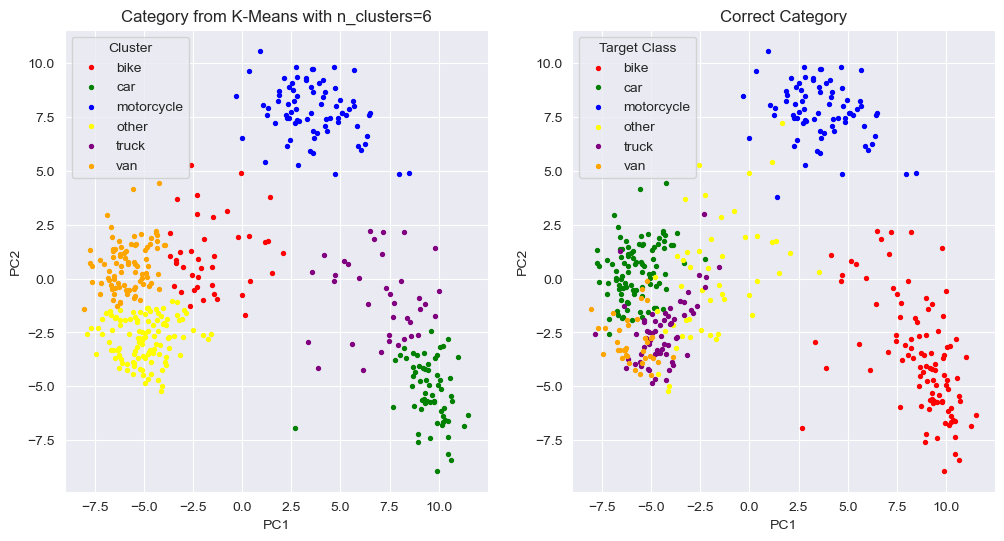

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First, plot labels obtained with K-means
for i, color in enumerate(colors):
    # Filter based on cluster labels assigned by k-means
    x1 = X_train_pca[kmeans.labels_ == i, 0]
    y1 = X_train_pca[kmeans.labels_ == i, 1]
    axs[0].scatter(x1, y1, s=8, color=color, label=class_names[i])
axs[0].set_xlabel('PC1')
axs[0].set_ylabel('PC2')
axs[0].legend(title='Cluster')
axs[0].set_title('Category from K-Means with n_clusters=6')

# Correct target category values
for i, color in enumerate(colors):
    # Filter according to target values
    x2 = X_train_pca[y_train == i, 0]
    y2 = X_train_pca[y_train == i, 1]
    axs[1].scatter(x2, y2, s=8, color=color, label=class_names[i])
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')
axs[1].legend(title='Target Class')
axs[1].set_title('Correct Category')

plt.show()

K-means does a good job of predciting motorcycle. But it totally misses for Vans. This plots show that PCA with 2 components and K-means with 6 is not performing well. We will have more KPIs from evaluating model on test in next section.

## Test set transformation using first two PCA components
### Transformation
Using the first two PCA components obtained form the training dataset, transform the test dataset.

In [16]:
X_test_pca = pca.transform(X_test)

### Visualization
Visualize the transformed data on a 2D-plot and use 6 different colors to designate the 6 categories. Based on this visualization, how many sample in the test dataset you think might be hard to classify?

In [17]:
X_test_pca.shape

(50, 2)

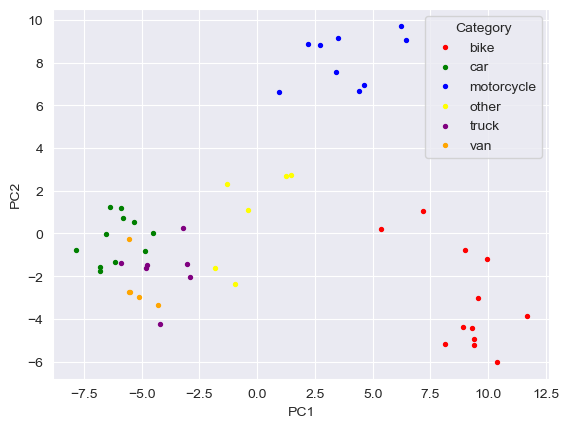

In [18]:
for i, color in enumerate(colors):
    plt.scatter(
        X_test_pca[y_test == i, 0],
        X_test_pca[y_test == i, 1],
        s=8,
        color=color,
        label=class_names[i]
    )


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Category')
plt.show()

Very similar to what was seen on train, samples in van, car and truck categories will be hard to classify.